In [258]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd())) # Insert all modules from the folder above
print(os.path.dirname(os.getcwd())) # Insert all modules from the folder above)
from tops.config import LazyConfig, instantiate


/Users/martinjohannesnilsen/NTNU/Datateknologi/2. semester/TDT4265 - Computer Vision and Deep Learning/project


In [259]:
config_path = "../configs/_test_anchors.py"
# PLOT_CIRCLE = True
PLOT_CIRCLE = False # Rectangles
fmap_idx_to_visualize = 5 # 0-5
aspect_ratio_indices = [5] # [0...5]

In [260]:
def plot_bbox(ax, box, color, circle=True):
    cx, cy, w, h = box
    cx *= cfg.train.imshape[1]
    cy *= cfg.train.imshape[0]
    w *= cfg.train.imshape[1]
    h *= cfg.train.imshape[0]
    x1, y1 = cx + w/2, cy + h/2
    x0, y0 = cx - w/2, cy - h/2
    if circle:
        ax.add_artist(matplotlib.patches.Ellipse([cx, cy], w,h, alpha=.1, color=color))
        plt.plot(cx, cy, f"o{color}")
    else:
        plt.plot([x0, x0, x1, x1, x0],[y0, y1, y1, y0, y0], f"{color}", alpha=.5)
        
def get_num_boxes_in_fmap(idx):
    boxes_per_location = 2 + 2*len(cfg.anchors.aspect_ratios[idx])
    feature_map_size = cfg.anchors.feature_sizes[idx]
    return int(boxes_per_location * np.prod(feature_map_size))

In [261]:
cfg = LazyConfig.load(config_path)
anchors = instantiate(cfg.anchors)(order="xywh")
print("Number of anchors:", len(anchors))
print("Aspect used for feature map:", cfg.anchors.aspect_ratios[fmap_idx_to_visualize])
# Set which aspect ratio indices we want to visualize
offset = sum([get_num_boxes_in_fmap(prev_layer) for prev_layer in range(fmap_idx_to_visualize)])

Number of anchors: 60080
Aspect used for feature map: [2, 3]


Total boxes: 48


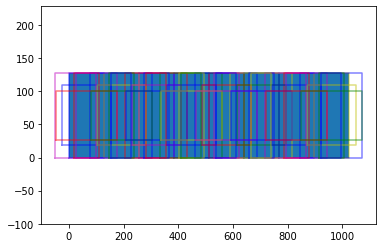

In [262]:
fig, ax = plt.subplots()

# Set up our scene
plt.ylim([-100, cfg.train.imshape[0]+100])
plt.xlim([-100, cfg.train.imshape[1]+100])

boxes_per_location = 2 + 2*len(cfg.anchors.aspect_ratios[fmap_idx_to_visualize])
indices_to_visualize = []
colors = []
available_colors = ["r", "g", "b", "y", "m", "b","w"]
for idx in range(offset, offset + get_num_boxes_in_fmap(fmap_idx_to_visualize)):
    for aspect_ratio_idx in aspect_ratio_indices:
        if idx % boxes_per_location == aspect_ratio_idx:
            indices_to_visualize.append(idx)
            colors.append(available_colors[aspect_ratio_idx])

ax.add_artist(plt.Rectangle([0, 0], cfg.train.imshape[1], cfg.train.imshape[0]))
for i, idx in enumerate(indices_to_visualize):
    prior = anchors[idx]
    color = colors[i]
    plot_bbox(ax, prior, color, PLOT_CIRCLE)
print("Total boxes:", len(indices_to_visualize))
plt.show()

### Prøve å forstå de ulike komponentene her

In [263]:
feature_sizes=[[32, 256], [16, 128], [8, 64], [4, 32], [2, 16], [1, 8]],
strides=[[4, 4], [8, 8], [16, 16], [32, 32], [64, 64], [128, 128]],
aspect_ratios=[[2, 3], [2], [2], [2], [2], [2, 3]],
min_sizes=[[16, 16], [32, 32], [48, 48], [64, 64], [86, 86], [128, 128], [128, 400]],

Først har man feature sizes, som definerer antall anchor boxes. Antallet bokser er x*y ([x, y]) * antall aspect ratios. Den lager altså x antall rader med bokser, y antall kolonner og lager (aspect_ratios) antall bokser fra disse senterpunktene.

Strides vil være plassen mellom hvert senterpunkt for anchorboxes. Ved siste feature size, som er færrest bokser, er det også høyest distanse. Dette gir mening. Hvor mye man skal flytte senterpunkt mens den iterer over bildet. Først tar man sikkert bildebredde delt på [w, h] i feature_sizes, og så strider man bortover med samme index fra strides.

aspect_ratios definerer høyde og bredde på de ulike boksene som lages, og er sentral her. Den tar utgangspunkt i min_sizes[i] og min_sizes[i+1] når den lager bokser. Virker som min_sizes ganges sammen med aspect_ratios da det å ha høye aspect ratios gir større bokser også. 

Min_sizes virker å være sentralt sammen med aspect_ratios til å påvirke størrelsen. 